In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import imageio
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from PIL import Image
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0)

In [2]:
def alternateSequentialFiltering(image):
    # ASF(alternate sequential filtering) Smooth the whole picture
    open1 = cv2.morphologyEx(image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=1)
    close1 = cv2.morphologyEx(open1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=1)
    open2 = cv2.morphologyEx(close1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13)), iterations=1)
    close2 = cv2.morphologyEx(open2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13)), iterations=1)
    open3 = cv2.morphologyEx(close2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21)), iterations=1)
    close3 = cv2.morphologyEx(open3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21)), iterations=1)
    return close3

def preProcess(i):
    image = cv2.imread('training/images/'+str(i)+'_training.tif')
    g = image[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_g_fundus = clahe.apply(g)
    R3 = alternateSequentialFiltering(contrast_g_fundus)
    
    plt.subplot(1,3,1)
    plt.imshow(g, cmap="gray")
    cv2.imwrite('./image/greenchannel/'+str(i)+'_bloodvessel.png', g)
    
    plt.subplot(1,3,2)
    plt.imshow(contrast_g_fundus, cmap="gray")
    cv2.imwrite('./image/clahe/'+str(i)+'_bloodvessel.png', contrast_g_fundus)
    
    plt.subplot(1,3,3)
    plt.imshow(R3, cmap="gray")
    cv2.imwrite('./image/filtering/'+str(i)+'_bloodvessel.png', R3)
    plt.show()

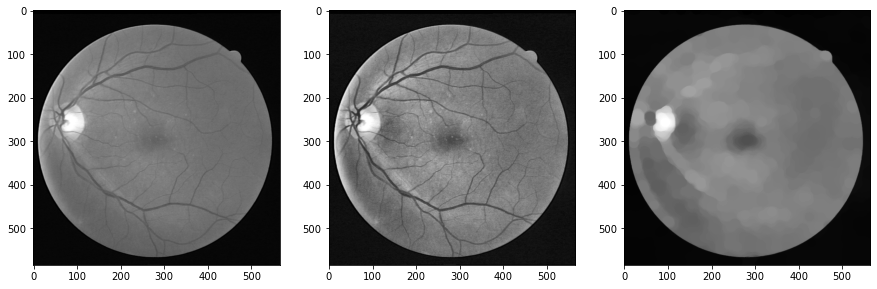

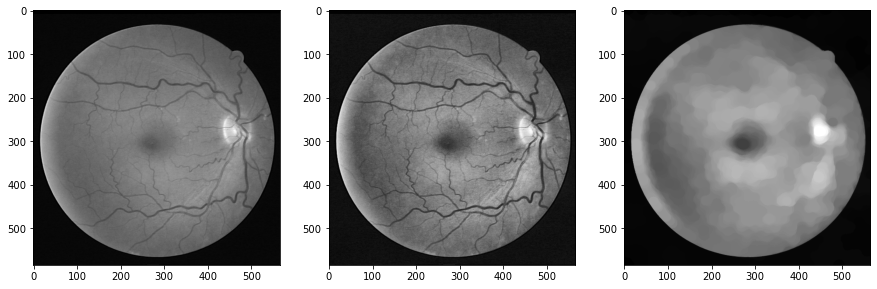

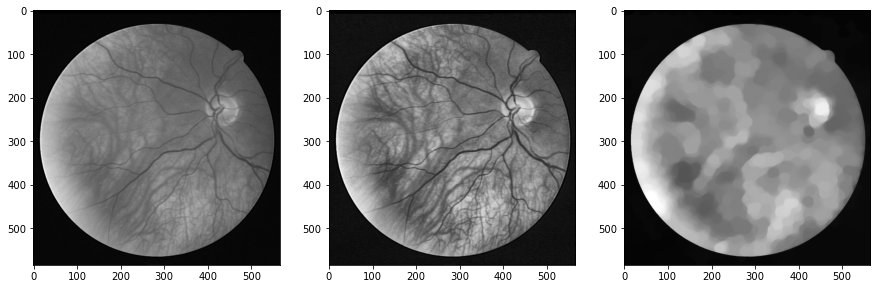

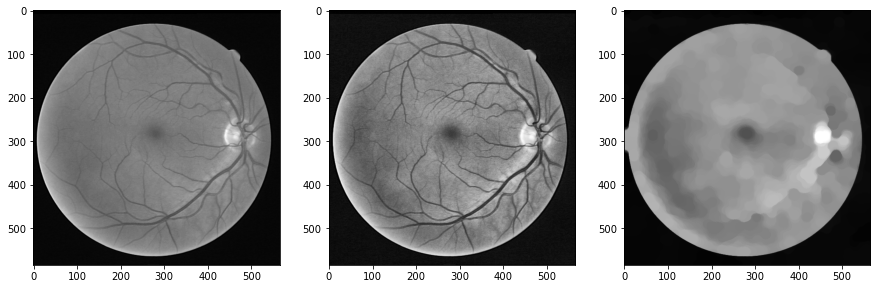

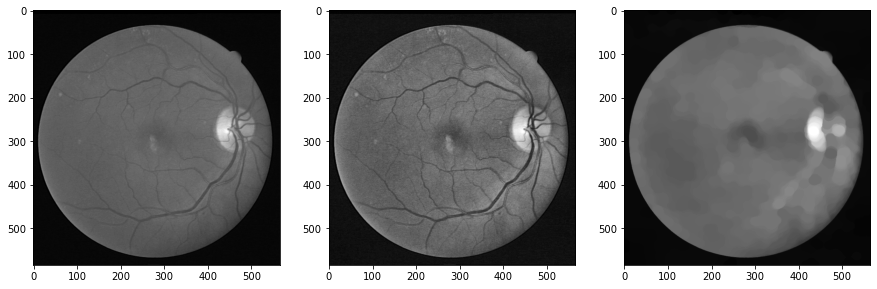

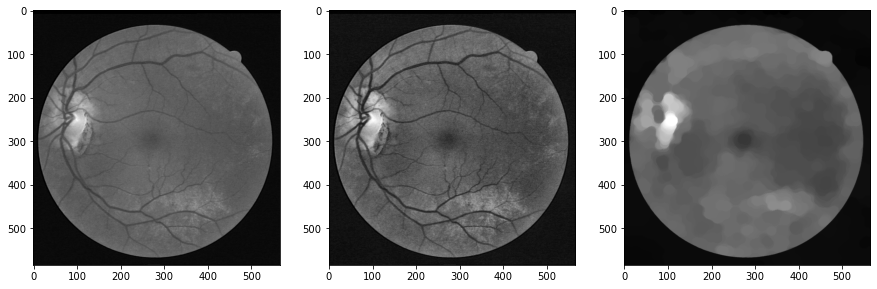

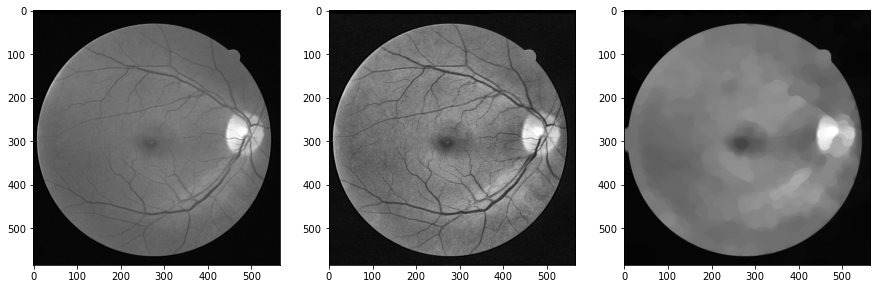

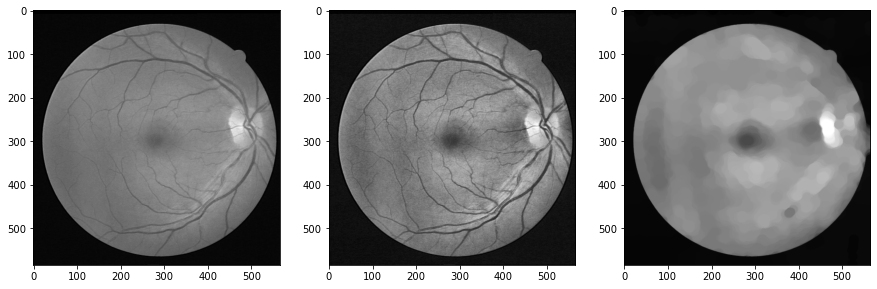

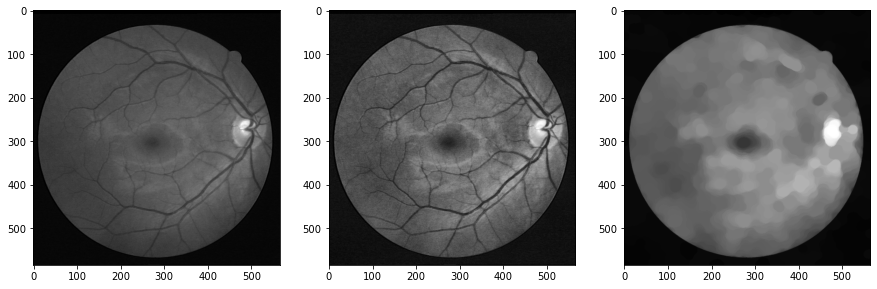

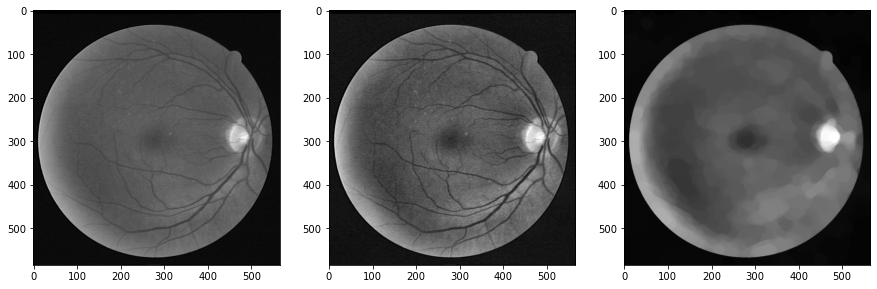

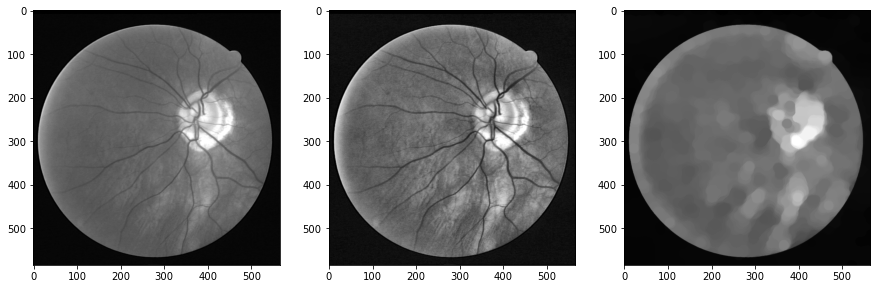

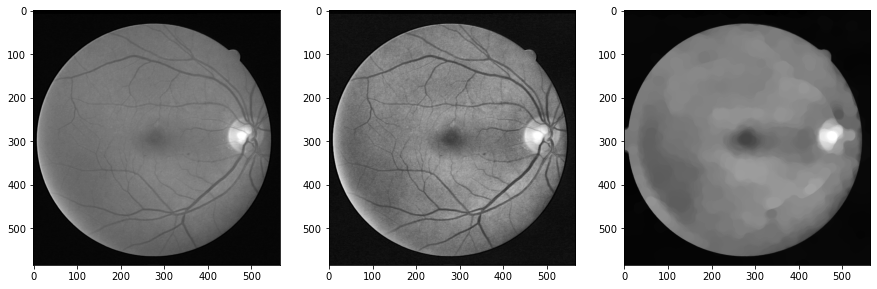

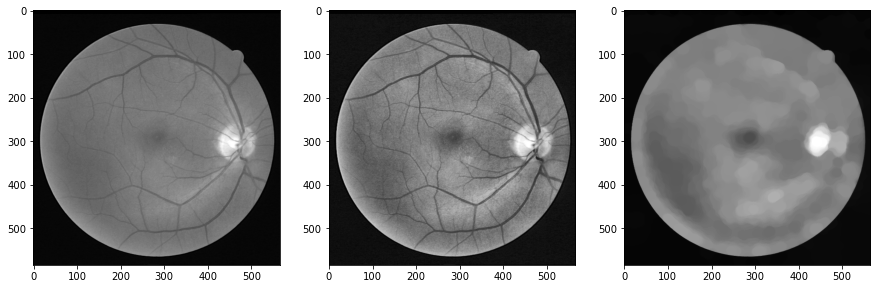

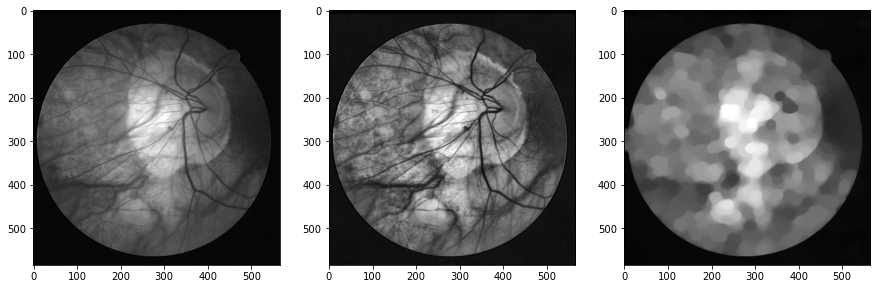

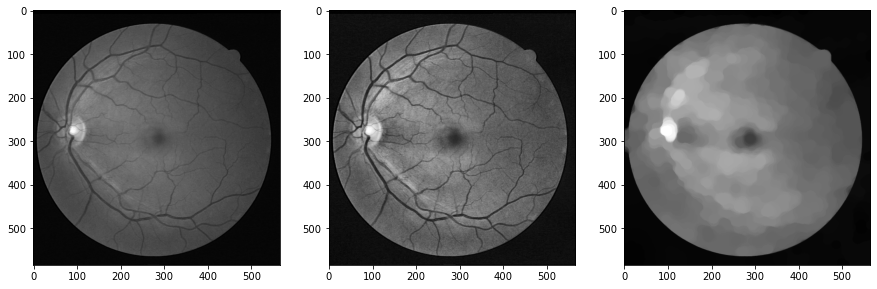

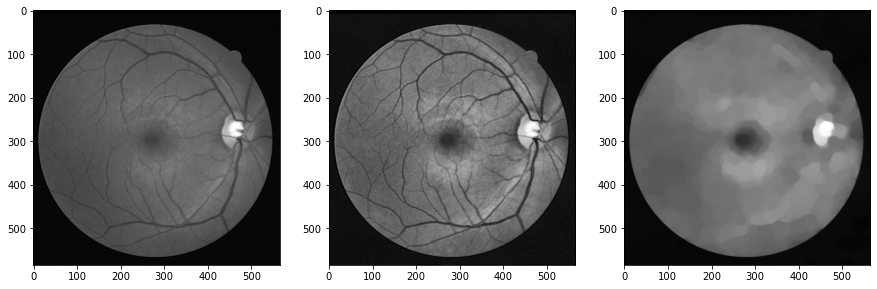

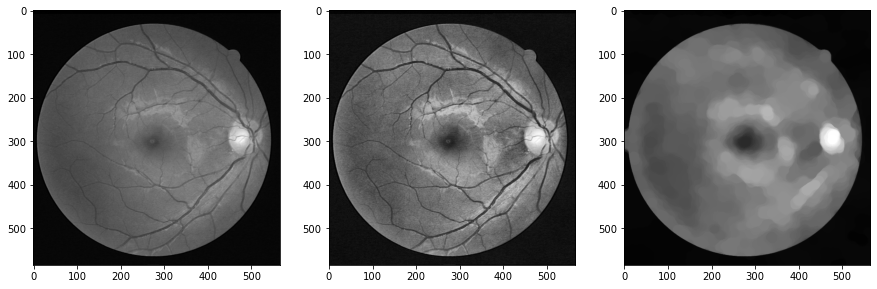

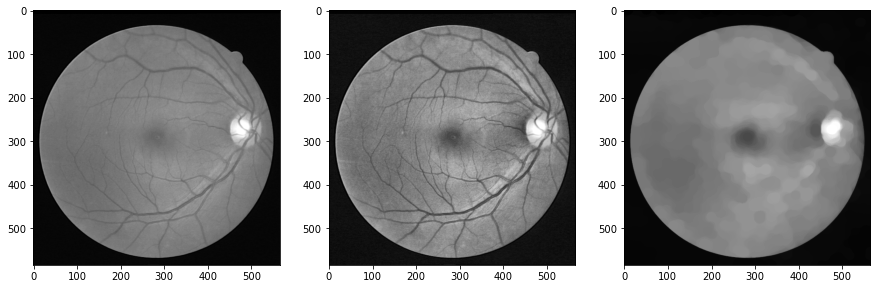

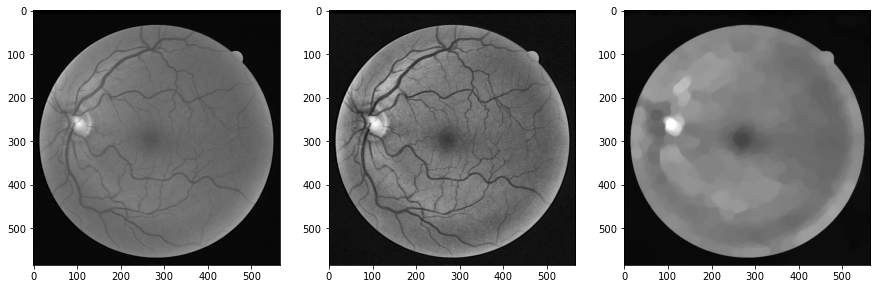

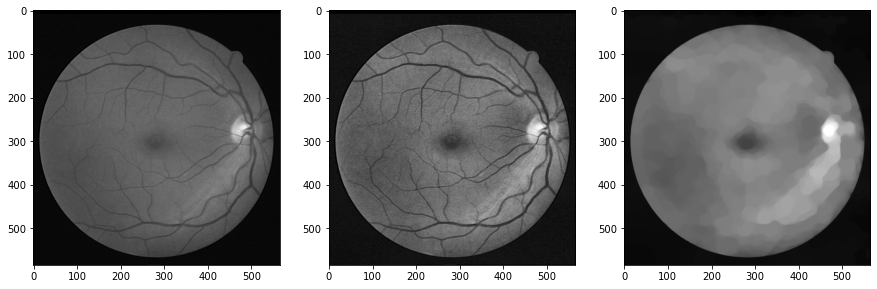

In [3]:
for i in range(21,41):
    preProcess(i)

In [4]:
def postProcess(i):
    image = cv2.imread('training/images/'+str(i)+'_training.tif')
    g = image[:, :, 1]
    im = Image.open('training/1st_manual/'+str(i)+'_manual1.gif')
    im = im.convert('RGB')
    label = np.asarray(im)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_g_fundus = clahe.apply(g)
    R3 = alternateSequentialFiltering(contrast_g_fundus)
    f4 = cv2.subtract(R3, contrast_g_fundus)
    f5 = clahe.apply(f4)
    f6 = clahe.apply(f5)
    f7 = clahe.apply(f6)
    
    _, thresh = cv2.threshold(f7, 15, 255, cv2.THRESH_BINARY)  #mapping array 0 atau 255 (item putih)
    maskSmallContour = np.ones(f7.shape[:2], dtype="uint8") * 255 #mapping array bernilai 255 (utk masking)
    contoursSmall, _ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) #
    for cnts in contoursSmall:
        if cv2.contourArea(cnts) <= 200: 
            cv2.drawContours(maskSmallContour, [cnts], -1, 0, -1)
    im = cv2.bitwise_and(f5, f5, mask=maskSmallContour)
    _, fin = cv2.threshold(im, 30, 255, cv2.THRESH_BINARY)

    plt.subplot(1,2,1)
    plt.imshow(im, cmap="gray")
    cv2.imwrite('./image/im/'+str(i)+'_bloodvessel.png', im)
    plt.subplot(1,2,2)
    plt.imshow(fin, cmap="gray")
    cv2.imwrite('./image/firstresult/'+str(i)+'_bloodvessel.png', fin)

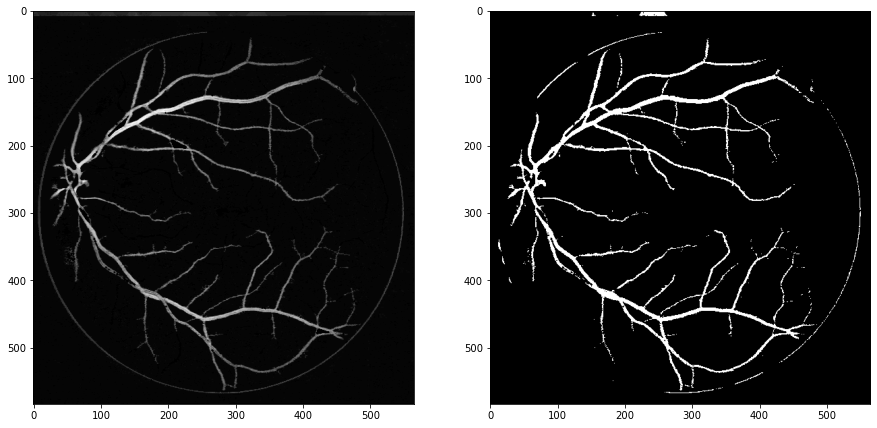

In [5]:
postProcess(21)

In [6]:
from PIL import Image
def removeBoarder(i):
    im = Image.open('training/mask/'+str(i)+'_training_mask.gif')
    im = im.convert('RGB')
    I = np.asarray(im)
    image = cv2.imread('image/firstresult/'+str(i)+'_bloodvessel.png')
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(I, kernel, iterations=3)
    result = cv2.bitwise_and(erosion, image)
    
    plt.subplot(1,3,1)
    plt.imshow(image, cmap="gray")
    plt.subplot(1,3,2)
    plt.imshow(erosion, cmap="gray")
    plt.subplot(1,3,3)
    plt.imshow(result, cmap="gray")
    cv2.imwrite('image/lastresult/'+str(i)+'_bloodvessel.png', result)

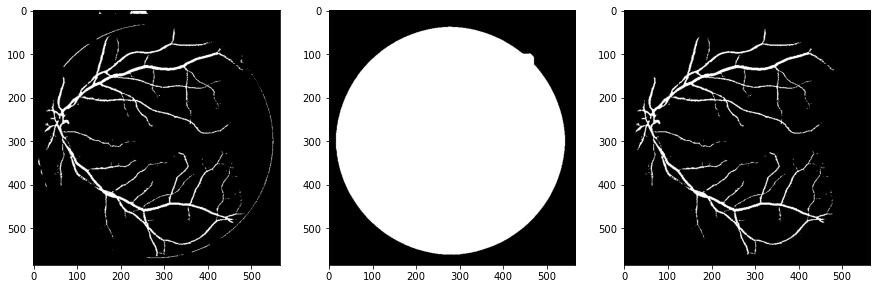

In [7]:
removeBoarder(21)

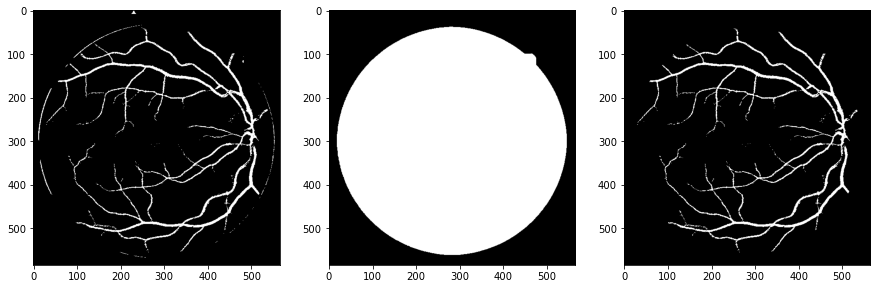

In [8]:
#generate 20 predict images
for i in range(21,41):
    postProcess(i)
    removeBoarder(i)

In [9]:
def showPicture(i):
    predict = cv2.imread('image/lastresult/'+str(i)+'_bloodvessel.png')
    origin = cv2.imread('training/images/'+str(i)+'_training.tif')
    origin = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)
    im = Image.open('training/1st_manual/'+str(i)+'_manual1.gif')
    im = im.convert('RGB')
    label = np.asarray(im)
    plt.subplot(1,3,1)
    plt.imshow(origin), plt.title(f"image {i}", {"fontsize": 20})
    plt.subplot(1,3,2), plt.title(f"manual {i}", {"fontsize": 20})
    plt.imshow(label, cmap="gray")
    plt.subplot(1,3,3), plt.title(f"predict {i} ", {"fontsize": 20})
    plt.imshow(predict, cmap="gray")
    plt.show()

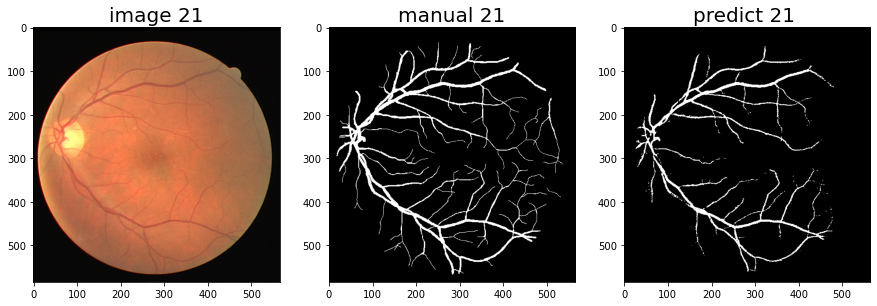

In [10]:
showPicture(21)

In [11]:
tn, fp, fn, tp = 0, 0, 0, 0

def accuracy(i):
    global tn, fp, fn, tp
    predict = cv2.imread('image/lastresult/'+str(i)+'_bloodvessel.png')
    im = Image.open('training/1st_manual/'+str(i)+'_manual1.gif')
    im = im.convert('RGB')
    I = np.asarray(im)
    for i in range(predict.shape[0]):                 
        for j in range(predict.shape[1]):
            if(predict[i,j].all()==I[i,j].all()):
                if(predict[i,j].all()==1):
                    tp+=1
                else:
                    tn+=1
            else:
                if(predict[i,j].all()==1):
                    fp+=1
                else:
                    fn+=1
   
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    print('current accuracy '+str(accuracy))

In [12]:
for i in range(21, 41):
    accuracy(i)

current accuracy 0.9661565038186447
current accuracy 0.9611074069584192
current accuracy 0.9559148583666707
current accuracy 0.9531064371438962
current accuracy 0.9496187416656564
current accuracy 0.9507152382106923
current accuracy 0.9514027674350137
current accuracy 0.9514100193962904
current accuracy 0.9520763459543917
current accuracy 0.9518568917444539
current accuracy 0.9534017897486197
current accuracy 0.953939366387845
current accuracy 0.9545858705484115
current accuracy 0.9526126543477131
current accuracy 0.9531145189315877
current accuracy 0.9525228436780215
current accuracy 0.9527942780943145
current accuracy 0.9530508748535176
current accuracy 0.9532107560087029
current accuracy 0.953730906776579


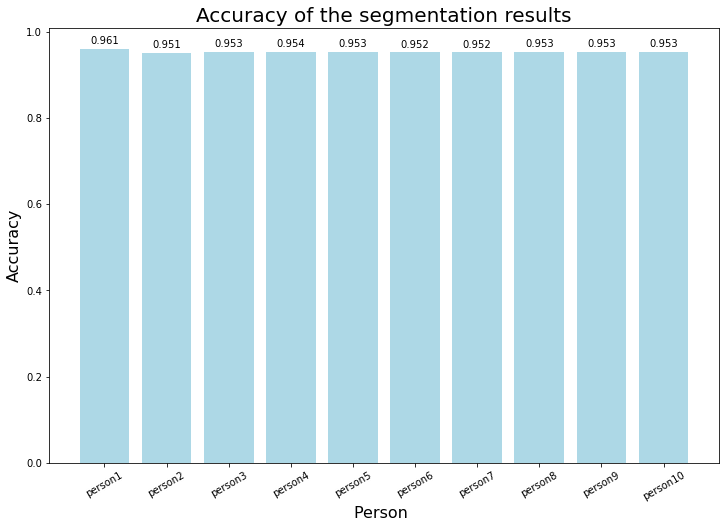

In [96]:
labels = ['person1', 'person2', 'person3','person4','person5', 'person6', 'person7','person8','person9','person10']
values = [0.961, 0.951, 0.953, 0.954, 0.953, 0.952, 0.952 , 0.953, 0.953, 0.953]
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(12, 8))
graph = ax.bar(x, values, width=0.8, color='lightblue')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(graph)
plt.xlabel('Person ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy of the segmentation results',fontsize=20)
plt.show()